In [1]:
import os

# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "tx-generator"

In [2]:
import operator
from typing import Annotated, List, Tuple, Literal

from IPython.display import Image, display

from graph.state import PlanSimulateState
from models.case import BatchCase

In [3]:
from graph.planner import planner

In [4]:
from graph.converter_tool import generate_tx_params

In [5]:
from graph.tools.simulation import simulate_transaction

In [ ]:
from graph.replanner import replan_step

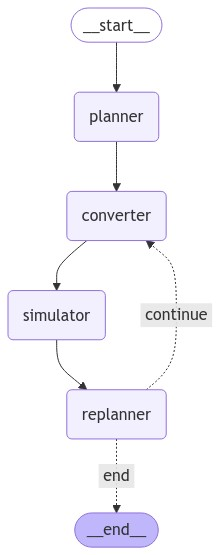

In [6]:
async def plan_step(state: PlanSimulateState):
    plan = await planner.ainvoke(state["input"])
    steps = [step.description for step in plan.steps]
    return {"steps": steps}


async def convert_step(state: PlanSimulateState):
    step = state["steps"][0]
    tx_params = await generate_tx_params(step, state["from_address"])
    return {"current_step": (step, tx_params)}


async def simulate_step(state: PlanSimulateState):
    step, tx_params = state["current_step"]
    print(f"Simulating step: {step}")
    simulated_txs = [tx for _, tx, _ in state["simulated_txs"]]
    txs = simulated_txs + [tx_params]

    result = await simulate_transaction.ainvoke({"transactions": txs})
    # Get the result of the last transaction
    last_tx_result = result.tx_results[-1]
    # If the last transaction is successful, add it to the list of simulated transactions
    if not last_tx_result.error:
        return {
            "simulated_txs": [(step, tx_params, last_tx_result.asset_changes)],
            # Remove the current step if the simulation is successful
            "steps": state["steps"][1:],
        }
    else:
        return {"error": last_tx_result.error}


def should_continue(state: PlanSimulateState) -> Literal["continue", "end"]:
    steps = state["steps"]
    if steps:
        return "continue"
    else:
        return "end"


from langgraph.graph import StateGraph, END

workflow = StateGraph(PlanSimulateState)
# Add nodes
workflow.add_node("planner", plan_step)
workflow.add_node("converter", convert_step)
workflow.add_node("simulator", simulate_step)
workflow.add_node("replanner", replan_step)

# Add edges
workflow.set_entry_point("planner")
workflow.add_edge("planner", "converter")
workflow.add_edge("converter", "simulator")
workflow.add_edge("simulator", "replanner")
workflow.add_conditional_edges(
    "replanner", should_continue, {"continue": "converter", "end": END}
)
# Create graph
app = workflow.compile()

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
input = {
    "from_address": "0xd8da6bf26964af9d7eed9e03e53415d37aa96045",
    "input": "Stake 0.03 ETH with Lido and deposit to Eigenpie",
}
await app.ainvoke(input, {"recursion_limit": 100})

In [7]:
input = {
    "from_address": "0xd8da6bf26964af9d7eed9e03e53415d37aa96045",
    "input": "Stake 0.03 ETH with Lido and deposit to Eigenpie",
}
await app.ainvoke(input, {"recursion_limit": 100})

Fetching ABI from Etherscan for address: 0xae7ab96520de3a18e5e111b5eaab095312d7fe84
Proxy contract detected at 0xae7ab96520de3a18e5e111b5eaab095312d7fe84
Implementation address: 0x17144556fd3424EDC8Fc8A4C940B2D04936d17eb
Fetching ABI from Etherscan for address: 0x17144556fd3424EDC8Fc8A4C940B2D04936d17eb
Not a proxy contract, returning the ABI
Simulating step: Stake 0.03 ETH to Lido to receive stETH.
Proxy contract detected at 0xae7ab96520de3a18e5e111b5eaab095312d7fe84
Implementation address: 0x17144556fd3424EDC8Fc8A4C940B2D04936d17eb
Not a proxy contract, returning the ABI
Simulating step: Approve 0.029999999999999999 stETH to be used by Eigenpie.
Fetching ABI from Etherscan for address: 0x24db6717dB1C75B9Db6eA47164D8730B63875dB7
Not a proxy contract, returning the ABI
Simulating step: Stake 0.029999999999999999 stETH to Eigenpie.
Simulating step: Approve 0.029999999999999999 stETH to be used by Eigenpie.
Not a proxy contract, returning the ABI
Simulating step: Stake 0.0299999999999999

CancelledError: 